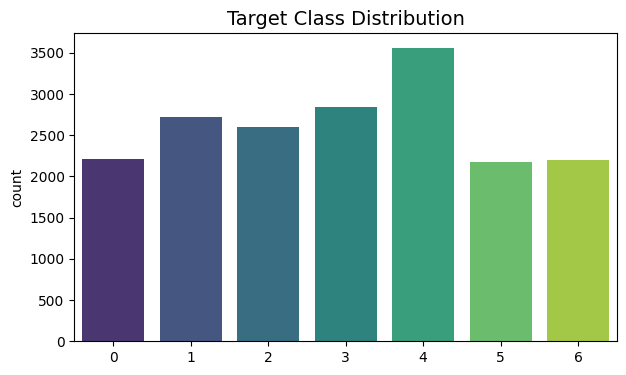

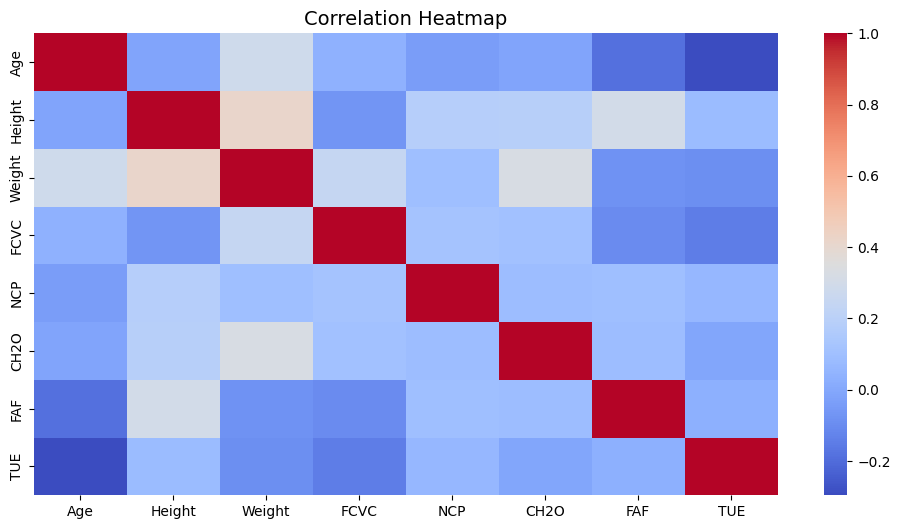

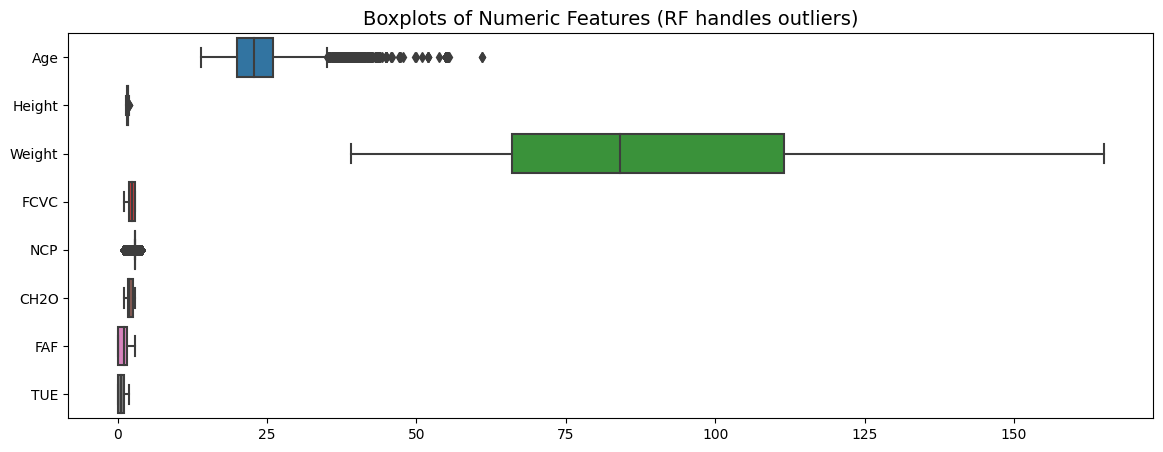

Validation Accuracy: 0.8850354997269252

Confusion Matrix:
 [[386  46   4   1   0   2   4]
 [ 18 471   9   0   0  30  16]
 [  0   3 447  15   4  17  34]
 [  0   1  11 545   1   1  11]
 [  1   0   1   2 706   2   0]
 [  1  36  13   2   2 339  41]
 [  1  10  26   3   0  52 347]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       443
           1       0.83      0.87      0.85       544
           2       0.87      0.86      0.87       520
           3       0.96      0.96      0.96       570
           4       0.99      0.99      0.99       712
           5       0.77      0.78      0.77       434
           6       0.77      0.79      0.78       439

    accuracy                           0.89      3662
   macro avg       0.88      0.87      0.87      3662
weighted avg       0.89      0.89      0.89      3662

Saved: Final_RF_Boosted_Fixed.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# ===========================================================
# LOAD DATA
# ===========================================================
train = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-c/train.csv")
test  = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-c/test.csv")

TARGET = "NObeyesdad"
ID_COL = "id"

# ===========================================================
# ENCODE TARGET LABELS (FIX FOR ERROR)
# ===========================================================
le = LabelEncoder()
y = le.fit_transform(train[TARGET])      # strings → numbers
X = train.drop([TARGET], axis=1)

test_id = test[ID_COL]
X_test = test.drop([ID_COL], axis=1)


plt.figure(figsize=(7,4))
sns.countplot(x=y, palette="viridis")
plt.title("Target Class Distribution", fontsize=14)
plt.show()

# Correlation heatmap (numeric only)
numeric_cols = X.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,6))
sns.heatmap(train[numeric_cols].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

# Boxplot for all numeric columns
plt.figure(figsize=(14,5))
sns.boxplot(data=X[numeric_cols], orient="h")
plt.title("Boxplots of Numeric Features (RF handles outliers)", fontsize=14)
plt.show()
# ===========================================================
# HANDLE MISSING VALUES
# ===========================================================
for col in X.select_dtypes(include=[np.number]).columns:
    X[col] = X[col].fillna(X[col].median())
    X_test[col] = X_test[col].fillna(X[col].median())

for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna(X[col].mode()[0])
    X_test[col] = X_test[col].fillna(X[col].mode()[0])

# ===========================================================
# ONE-HOT ENCODING
# ===========================================================
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X, X_test = X.align(X_test, join="left", axis=1)
X_test = X_test.fillna(0)

# ===========================================================
# TRAIN/VAL SPLIT
# ===========================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================================================
# FEATURE IMPORTANCE BASED SELECTION
# ===========================================================
rf_base = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)

importances = pd.Series(rf_base.feature_importances_, index=X.columns)
selected_features = importances[importances > 0.002].index   # tuned threshold

X = X[selected_features]
X_test = X_test[selected_features]

# re-split after feature selection
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===========================================================
# TOP-TUNED RF MODELS (ENSEMBLE OF 3)
# ===========================================================
def make_rf(seed):
    return RandomForestClassifier(
        n_estimators=1600,
        max_depth=34,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        bootstrap=True,
        class_weight="balanced",
        random_state=seed,
        n_jobs=-1
    )

rf1 = make_rf(42)
rf2 = make_rf(21)
rf3 = make_rf(99)

cal1 = CalibratedClassifierCV(rf1, method="sigmoid", cv=3)
cal2 = CalibratedClassifierCV(rf2, method="sigmoid", cv=3)
cal3 = CalibratedClassifierCV(rf3, method="sigmoid", cv=3)

cal1.fit(X_train, y_train)
cal2.fit(X_train, y_train)
cal3.fit(X_train, y_train)

# ===========================================================
# VALIDATION
# ===========================================================
val_proba = (cal1.predict_proba(X_val) +
             cal2.predict_proba(X_val) +
             cal3.predict_proba(X_val)) / 3

val_pred = np.argmax(val_proba, axis=1)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, val_pred))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

# ===========================================================
# TRAIN ON FULL DATA
# ===========================================================
cal1.fit(X, y)
cal2.fit(X, y)
cal3.fit(X, y)

# ===========================================================
# FINAL TEST PREDICTION
# ===========================================================
test_proba = (cal1.predict_proba(X_test) +
              cal2.predict_proba(X_test) +
              cal3.predict_proba(X_test)) / 3

test_pred = np.argmax(test_proba, axis=1)

# Convert back to original labels
test_pred_labels = le.inverse_transform(test_pred)

# ===========================================================
# SUBMISSION
# ===========================================================
submission = pd.DataFrame({
    ID_COL: test_id,
    TARGET: test_pred_labels
})

submission.to_csv("Predictions.csv", index=False)
print("Saved: Final_RF_Boosted_Fixed.csv")
